### Fuels Parameterization

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime, math
from scipy import stats
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations
DFFSDir = 'C:/Research/Dinkey_Creek/DFFS_Data/FireWeather/'

#### Fuels parameterization investigation
The fuels treatments effects are totally cattywompus. In an effort to figure out whats going on, we need to really get a handle on what a, b, and c (coefficients in the dynamic fuels extension) are, and how they perturb fuels rate of spread.
The rate of spread (RSI) of fire events for all conifer fuel types is defined as:

####RSI = a * [1 - e$^{-b * ISI}$] $^{c}$

The ISI, or initial spread index, is a function of wind speed f(W), and the fuel moisture effect f(F)
Here, f(W) is a fixed function of wind speed. f(F) however is a function of FFMC (fine fuel moisture code). Therefore, both f(F), and f(W) and consequently ISI are primarily fire weather driven, and should be independent of the fuels conundrum. Here I'll describe a few functions to recreate the equations described in the fuels handbook (https://www.for.gov.bc.ca/hfd/pubs/docs/frh/Frh012.pdf) and recreate the surfaces derived from those equations, for each of our fuel types and treatments. 

In [8]:
# Read in fire weather data for Dinkey, freshly minted
fireWeather = pd.read_csv('Z:\DinkeyFW_Historic.csv')

# Read in a modified fuels spreadsheet 
#(more or less copied out of the Dynamic Fire and Fuels param file.)
DinkeyFuels = pd.read_csv('Z:\DinkeyFuels.csv')

# Here's the format for the fuels param file
DinkeyFuels.head()

,LANDIS_Code,Base Type,FBP_Code,IgnProb,a,b,c,q,BUI,maxBE,CBH,FuelName
0,50,Open,O1b,0.010,250,0.035,1.7,1.00,1,1.000,0,Open
1,2,Deciduous,D1,0.005,30,0.015,2.0,0.90,32,1.179,1,"oak, madrone, maple"
2,3,Deciduous,D1,0.005,30,0.015,2.0,0.90,32,1.179,2,"oak, madrone, maple"
3,4,Conifer,C1,0.010,110,0.024,3.0,0.90,64,1.321,1,juniper-pinyon
4,6,Conifer,C7,0.010,90,0.020,3.2,0.85,64,1.321,1,Ponderosa young


#### Define the functions described in the FBP
To really get at fuels effects on fire, and subsequently treatment effects on fire behavior, we need to be able to see how the changes we make to the slew of fuels parameters actually affect important determinants of fire intensity and size. The functions to convert fire weather inputs to the drivers of fire size and inensity calculations are below

I could have gone through and labeled the equations per the FBP equation numbers, but thats a waste of time. Parsimony damnit.. We just need to get to surfaces of Rate Of Spread, and that will be good enough to ask our questions about fuels treatments.

In [9]:
# Define ISI (initial spread index)
def calcISI(fWSV, fFFMC):
    ISI = [0.208 * a*b for a,b in zip(fWSV, fFFMC)]  
    return ISI

# define f(W)
def windEffect(WSV):
    fW = []
    for Wind in WSV:
        if Wind <= 40:
            fWE = np.exp(0.05039 * Wind)
        else:
            fWE = 12 * (1 - np.exp(-0.0818 * (Wind - 28)))
        fW.append(fWE)
    return fW

# define f(F)
def fuelMoistureEffect(FFMC):
    fM = (147.2 * (101 - FFMC)) / (59.5 + FFMC)
    fF = 91.9 * np.exp(-0.1386 * fM) * (1 + ((fM ** 5.31) / (4.93 * (10**7))))
    return fF

# define RSI
# Rate of Spread index (RSI) is a function of weather and fuels, so we need to
# associate this function with our fuels dataframe.
# fuelsDF  -- dataframe containing the dynamic fire fuels parameterization
# fuelCode -- the fuel index assocaited with the fuel type by the dynamic fuels extension
# ISI      -- an initial spread index (function of WSV and FFMC)
def rateOfSpreadIndex(fuelsDF, fuelCode, ISI):
    FC = fuelsDF[fuelsDF.LANDIS_Code == fuelCode]
    a = FC.a
    b = FC.b
    c = FC.c
    RSI = a * (1 - np.exp(-b * ISI)) ** c
    return RSI

# define BE
# Buildup Effect (BE), just like RSI, is calculated using both weather 
# data AND fuels constants.
# fuelsDF  -- dataframe containing the dynamic fire fuels parameterization
# fuelCode -- the fuel index assocaited with the fuel type by the dynamic fuels extension
# ISI      -- a buildup index (calculated from RAWS data, based on time since precip, TA, and rH)
def buildUpEffect(fuelsDF, fuelCode, BUI):
    FC = fuelsDF[fuelsDF.LANDIS_Code == fuelCode]
    q = FC.q
    BUI_0 = FC.BUI
    BE = np.exp(50. * np.log(q)*((1/BUI)-(1/BUI_0)))
    return BE

ISI = calcISI(windEffect(fireWeather.WSV), fuelMoistureEffect(fireWeather.FFMC))

### We can now generate fuels and treatment specific surfaces for rate of spread (ROS), for the range of fire weather events indicated in the FBP. 
The strategy herer will be to create a surface, where each grid cell represents the Rate of Spread (m/min) of fire, for a given Initial Spread Index (windspeed and surface fuels), and Buildup Index (time since precip, and realistically time since fire). We can create one of these surfaces for each fuel type in our fuel table. 

In [10]:
# fuelsROS(fuelsDF, fuelCODE, ISIarray, BUIarray)
# fuelsDF  -- dataframe containing the dynamic fire fuels parameterization
# fuelCode -- the fuel index assocaited with the fuel type by the dynamic fuels extension
# ISIarray -- An array of ISI values 
# BUIarray -- An array of BUI values
# returns RSI_df, a pandas dataframe, with column and row names set to the BUI and ISI 
# array values respectively
def fuelsROS(fuelsDF, fuelCode, ISIarray, BUIarray):
    RSI_A = np.zeros((len(ISIarray), len(BUIarray)))
    row = 0
    col = 0
    for isi in ISIarray:
        for bui in BUIarray:
            RSI_A[row][col] = np.floor(rateOfSpreadIndex(fuelsDF,fuelCode,isi) \
            * buildUpEffect(fuelsDF,fuelCode,bui))        
            col = col + 1
        col = 0
        row = row + 1
    RSI_df = pd.DataFrame(RSI_A)
    RSI_df.index = ISI_L.astype(int)
    RSI_df.columns = BUI_L.astype(int)

    return RSI_df

### Rate of Spread gets us most of the way to fire severity draws
In order to understand how changes in Rate of Spread affect fire severity, first we have to get a handle on what it means in LANDIS specifically. First of all, its important to understand that fire severity (classes from 1-5) are assigned as a final step in the DFFS in LANDIS, based on the portion of the canopy that burns (CFB, crown fraction burned). 
####CSI = 0.001 * CBH$^{1.5}$ * (460 + 25.9 * FMC) $^{1.5}$
where FMC (Foliar Moisture Code) is a user defined seasonal constant (varies as a function of season), CBH is a fuel type constant, and CSI is used in the calculation of RSO, the critical surface fire spread rate:
####RSO = CSI / (300 * SFC)
where SFC is a base fuel type specific function. Finally, CFB defined as:
####CFB = 1 – e$^{-0.23  (ROS – RSO)}$
where ROS is rate of spread, as described above.

### So we need to define some functions to calculate these fire and fuels variables:


In [14]:
# Lets start with FMC -- We have to create a lookup-table to make 
# our FMC calculation flexible across fuel types
def calcSFC(FBP_Code, BUI, FFMC):
    if FBP_Code == 'C1':
        SFC = 1.5 * (1 - np.exp(-0.2230 * (FFMC - 81.)))
        if SFC < 0:
            SFC = 0
    if FBP_Code in ['C2', 'M3','M4']:
        SFC = 5.0 * (1 - np.exp(-0.0115 * BUI))
    if FBP_Code in ['C3', 'C4']:
        SFC = 5.0 * (1 - np.exp(-0.0164 * BUI))^2.24
    if FBP_Code in ['C5', 'C6']:
        SFC = 5.0 * (1 - np.exp(-0.0149 * BUI))^2.48
    if FBP_Code == 'C7':
        FFC = 2 * (1 - np.exp(-0.104 * (FFMC - 70)))
        if FFC < 0:
            FFC = 0
        WFC = 1.5 * (1 - np.exp(-0.0201 * BUI))
        SFC = FFC + WFC
    if FBP_Code == 'D1':
        SFC = 1.5 * (1 - np.exp(-0.0183 * BUI))
    return SFC

# Function DEF
def calcCSI(fuelsDF, fuelCode, FMC):
    FC = fuelsDF[fuelsDF.LANDIS_Code == fuelCode]
    CBH = FC.CBH
    CSI = 0.001 * CBH^1.5 * (460. + 25.9 * FMC)^1.5
    return CSI

# Function DEF
def calcRSO(CSI, SFC):
    RSO = CSI / (300. * SFC)
    return RSO

# Function DEF
def calcCFB(ROS, RSO):
    CFB = 1 - np.exp(-0.23 * (ROS - RSO))
    return CFB

Great, now we can take ROS, and with the critical surface fire spread rate, and calculate the crown fraction burned (CFB). CFB is the soup to nuts calculation of fire severity -- we can turn CFB into a LANDIS severity draw, and couple it with a range of Biomass values to even estimate the corresponding C Efflux due to fire. However, getting at CFB in a multivariate, surface sort of way, requires too much dimensionality to easily visualize.. and if we look at the equations that support it, really its unncesseary. If we can reduce the ROS of a fire event across a fuel type, we will reduce its corresponding fire severity draw: Parsimony!

### ROS surfaces for each fuel type in the fuel table

With that way of life in mind, lets crank out some ROS surfaces for our fuel types.

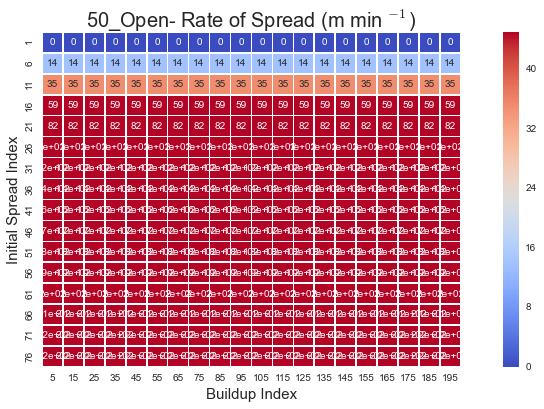

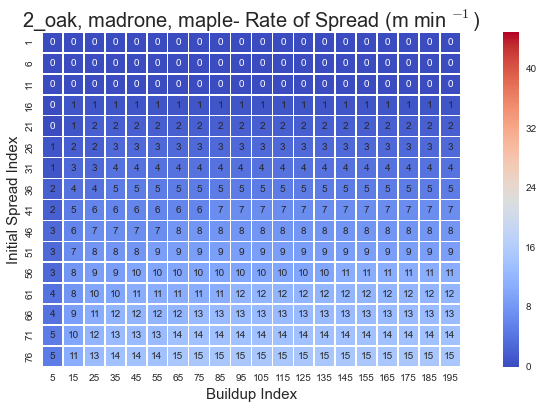

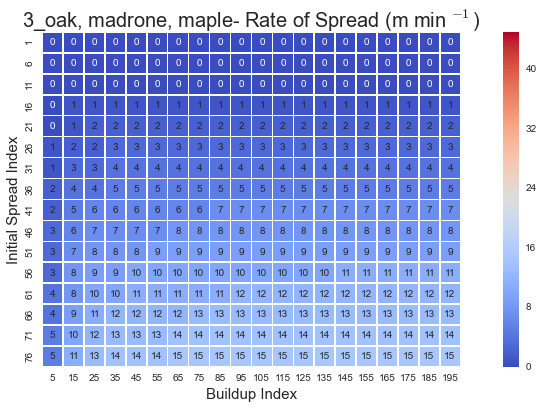

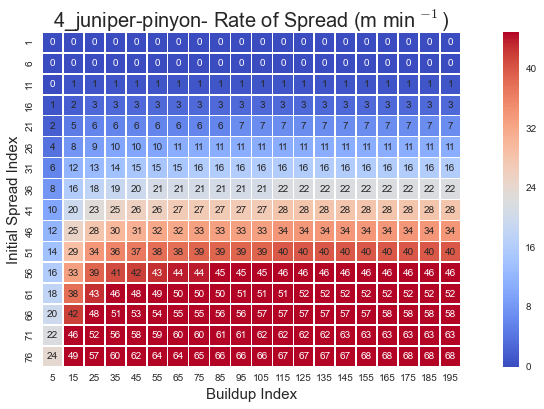

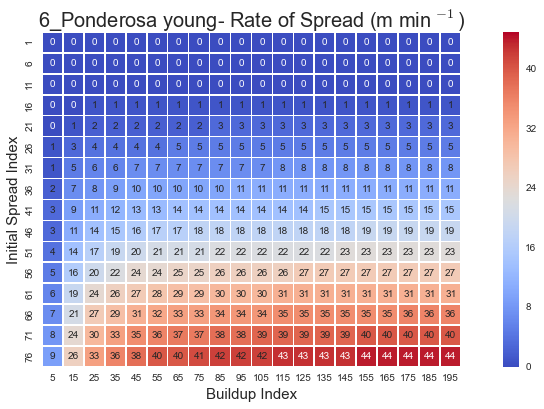

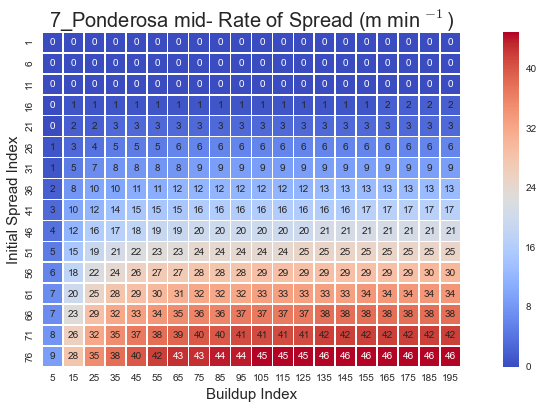

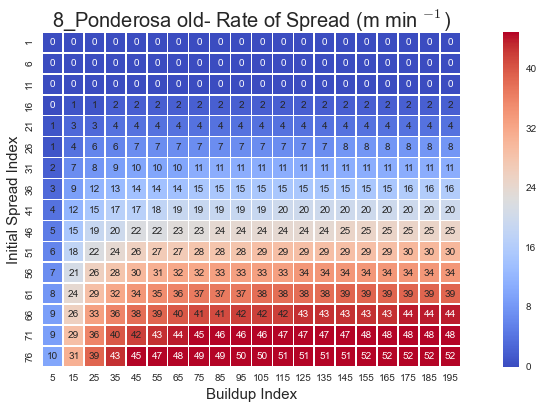

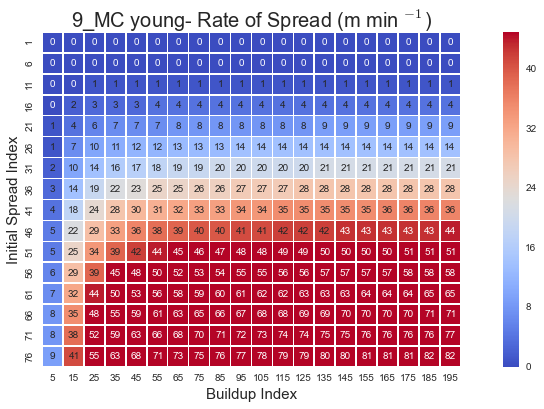

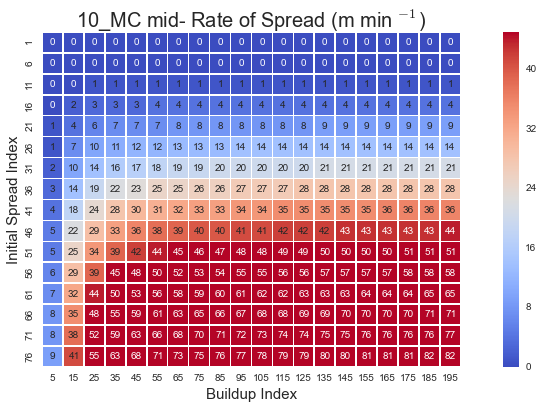

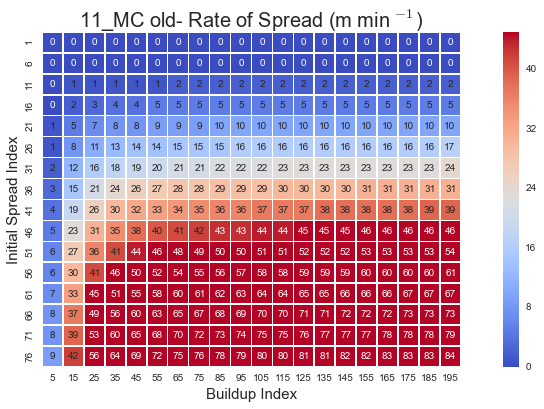

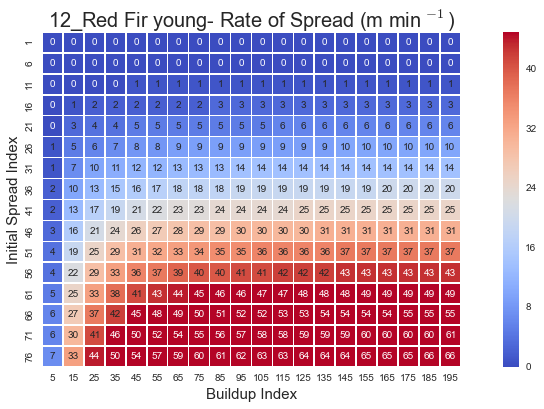

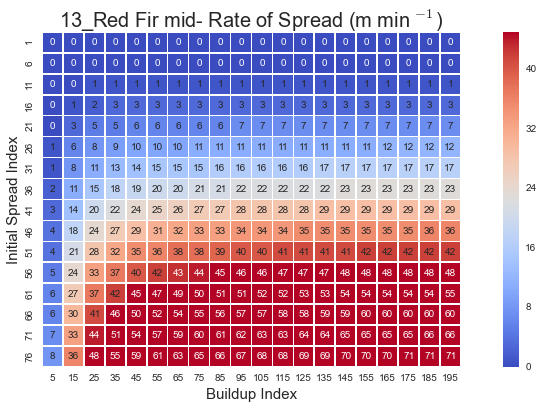

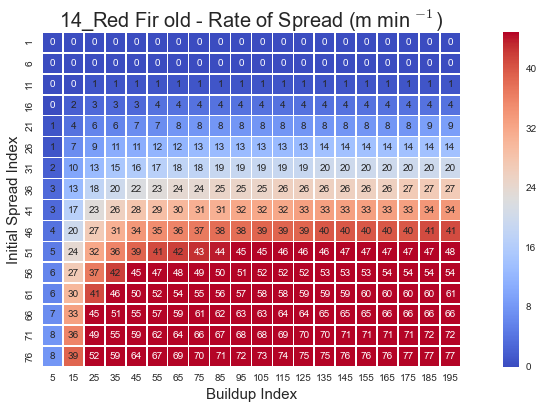

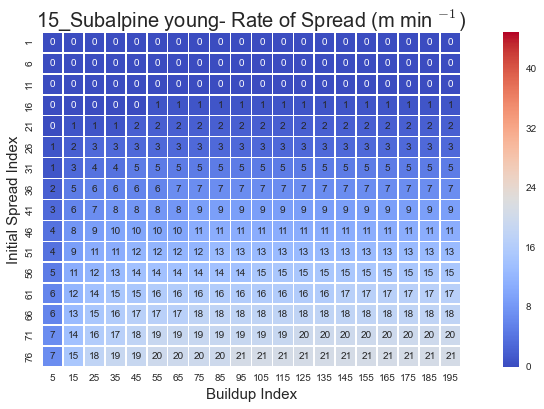

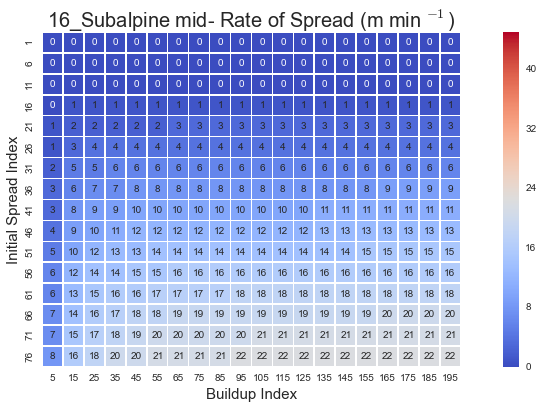

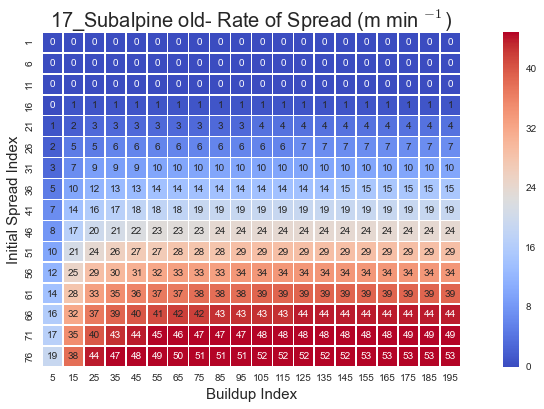

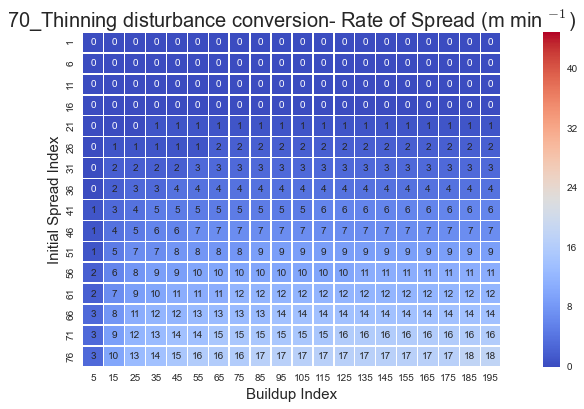

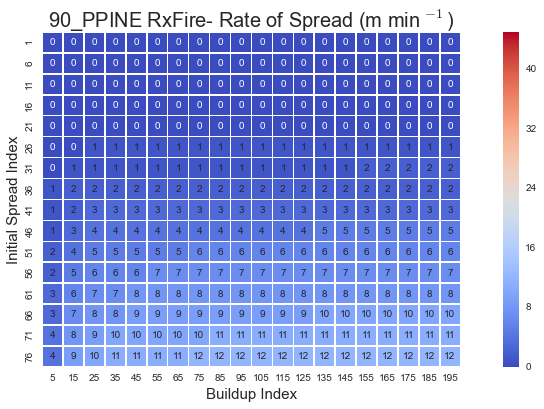

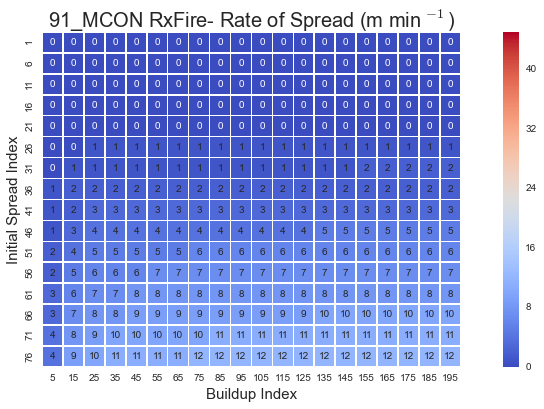

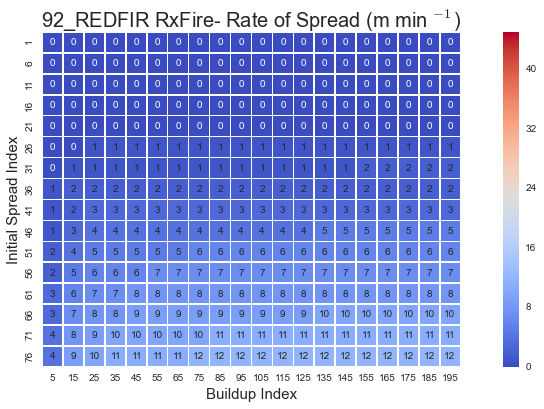

In [16]:
# Generate the arrays for ISI and BUI, bounded by the limits seen in the FBP
ISI_L = np.arange(1.,80.,5.)
BUI_L = np.arange(5.,205.,10.)
for fuelType in DinkeyFuels.LANDIS_Code:
    fuelName = DinkeyFuels[DinkeyFuels.LANDIS_Code == fuelType].FuelName.ravel()[0]
    ROS_Surface = fuelsROS(DinkeyFuels, fuelType, ISI_L, BUI_L)
    f, (ax) = plt.subplots(1,1, figsize =(15,6))
    sns.heatmap(ROS_Surface, square=True, linewidths=0.2, 
                annot=True, cmap = "coolwarm", vmin = 0, vmax = 45)
    ax.set_xlabel('Buildup Index', fontsize = 15)
    ax.set_ylabel('Initial Spread Index', fontsize = 15)
    ax.set_title(str(fuelType) + '_' + fuelName + '- Rate of Spread (m min $^{-1}$)', 
                 fontsize = 20)
    plt.savefig(fuelName + '.tiff')

### What about when we treat the landscape?
So LANDIS basically lets you change the fuel type in a treated grid cell to a new type (or following a severe fire event for instance) so you can adjust fire behavior in that grid cell. For our purposes, we want to make sure that our treatment is altering fire ROS as we would expect, across the range of ISI and BUI (remember, ISI and BUI are essentially windspeed and dryness, plus time since fire) present in our fire weather.

The strategy here is pretty simple, simply calculate the ROS surfaces for each treated fuel type, and difference that from the post disturbance fuel type (from the damage conversion table). Subsequent decreases in ROS should be realized as a treatment effect on fire ROS.

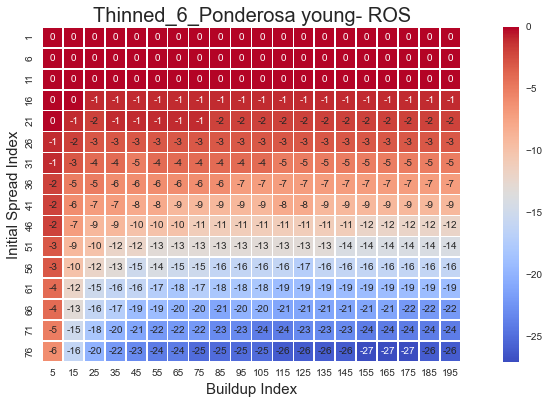

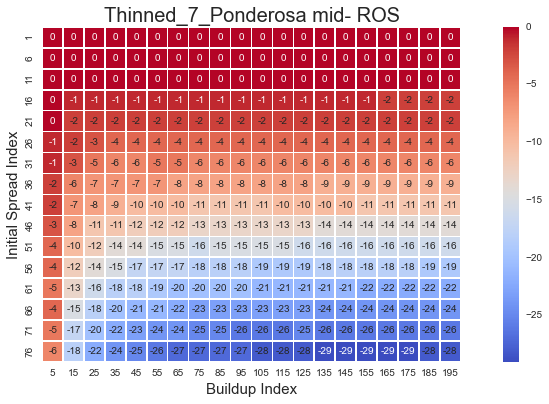

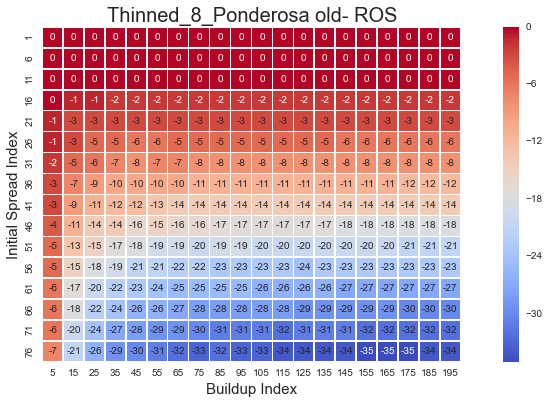

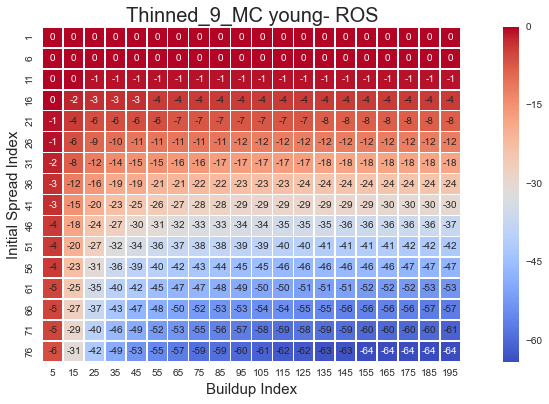

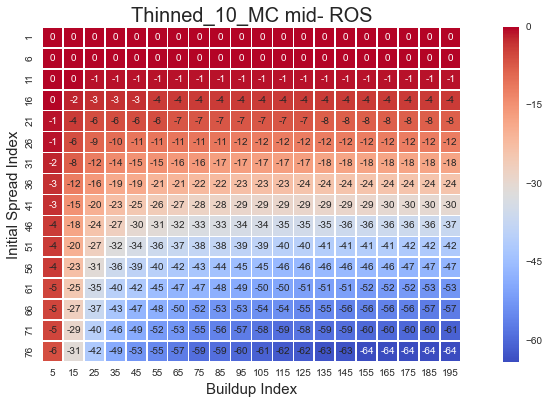

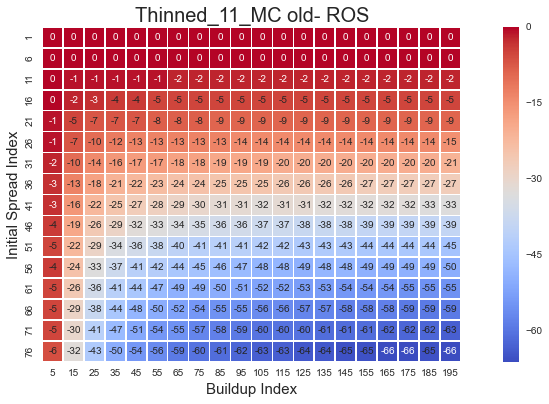

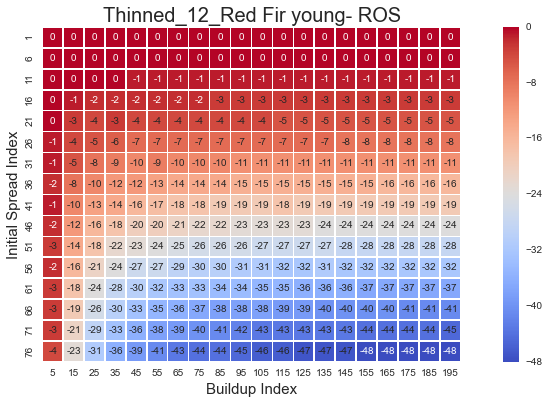

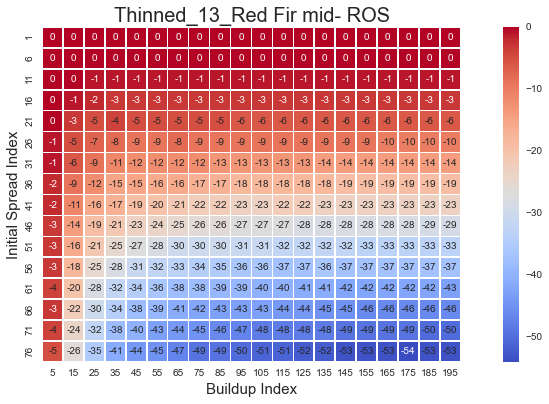

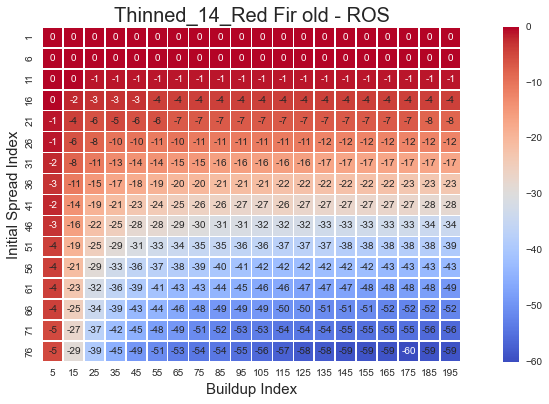

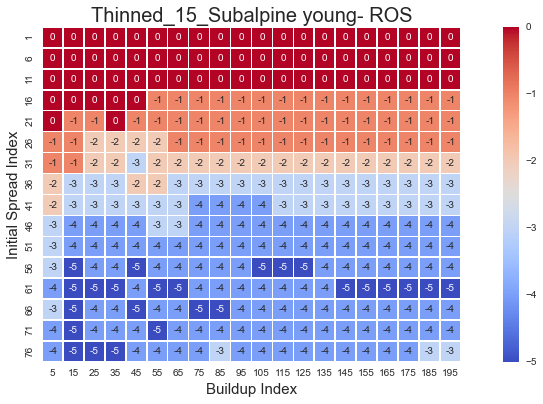

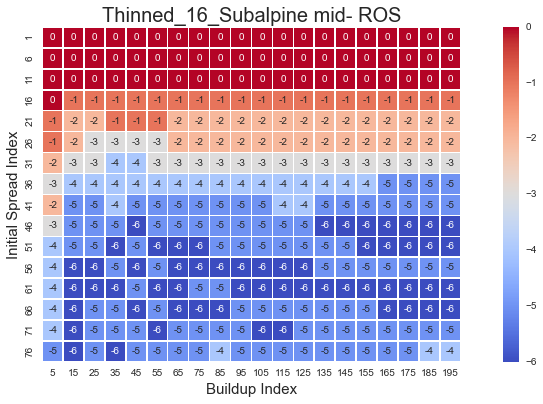

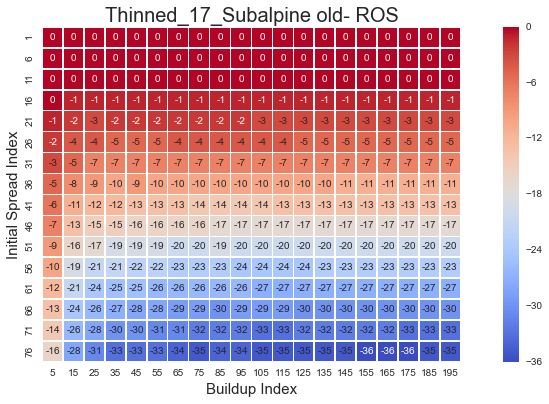

In [17]:
# Define the fuel codes that get treated
# All treated fuel types receive the same mechanical thinning
toThin = np.arange(6, 18, 1)
ROS_Thinning = fuelsROS(DinkeyFuels, 70, ISI_L, BUI_L)

for fuelType in toThin:
    fuelName = DinkeyFuels[DinkeyFuels.LANDIS_Code == fuelType].FuelName.ravel()[0]
    ROS_Surface = fuelsROS(DinkeyFuels, fuelType, ISI_L, BUI_L)
    treatmentEffect = ROS_Thinning - ROS_Surface
    f, (ax) = plt.subplots(1,1, figsize =(15,6))
    sns.heatmap(treatmentEffect, square=True, linewidths=0.2, 
                annot=True, cmap = "coolwarm")
    ax.set_xlabel('Buildup Index', fontsize = 15)
    ax.set_ylabel('Initial Spread Index', fontsize = 15)
    ax.set_title('Thinned_' + str(fuelType) + '_' + fuelName + '- ROS', 
                 fontsize = 20)
    plt.savefig('Thin_' + fuelName + '.tiff')

### Looks good
Now we can get on with running simulations, and generating output figures for the analysis.